In [1]:
#configure notebook
import warnings
warnings.filterwarnings('ignore')

#import packages
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
#from lmfit import Model
#from lmfit import Parameters
%matplotlib inline

from statistics import mean
import scipy
from pathlib import Path
from operator import truediv

# Measurement Characterization and Filepaths

In [2]:
#choose filepath to desired data
path = '/Volumes/KESU/image_data/'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/Volumes/KESU/calibration_files/cam1pixel.h5'
cal_file1 =  '/Volumes/KESU/calibration_files/cam2pixel.h5'

In [3]:
waves= np.linspace(7,12,61)

In [4]:
#select ROI
ymin2 = 105; ymax2 = 135;
ymin1 = 140; ymax1 = 170;

FOV = 53.51 ;
HFOV = 5;
view_angle = np.round(np.linspace(-HFOV,HFOV,ymax2-ymin2))

### Check an intermediate image

28.1
-9.299999999999997
28.0
-9.5


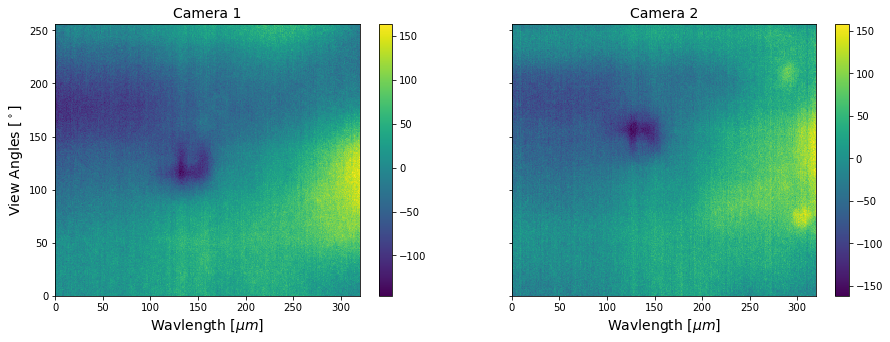

In [10]:
filename_ground = path + 'Capture'+str(1366)+'.hdf5'

filename = path + 'Capture'+str(1800)+'.hdf5'


with h5py.File(filename, "r") as file:
    image1 = np.mean(file['image1'][()],axis = 0)
    image2 = np.mean(file['image2'][()],axis = 0)
    t1 = np.mean(file['temp1'][()])
    t2 = np.mean(file['temp2'][()])
    
with h5py.File(filename_ground, "r") as file:
    image1g = np.mean(file['image1'][()],axis = 0)
    image2g = np.mean(file['image2'][()],axis = 0)
    t1g = np.mean(file['temp1'][()])
    t2g = np.mean(file['temp2'][()])


c1 = (image1-np.mean(image1))
print(t1)
print(t1-t1g)

c2 = (image2-np.mean(image2))
print(t2)
print(t2-t2g)

#plot test images, test appearance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)

p1 = axes[0].pcolormesh(c1,shading = 'auto')
fig.colorbar(p1, ax=axes[0])
axes[0].set_title('Camera 1',fontsize = 14)
axes[0].set_ylabel('View Angles [$^\circ$]',fontsize = 14)
axes[0].set_xlabel('Wavlength [$\mu m$]',fontsize = 14)

p2 = axes[1].pcolormesh(c2,shading = 'auto')
axes[1].set_title('Camera 2',fontsize = 14)
axes[1].set_xlabel('Wavlength [$\mu m$]',fontsize = 14)
fig.colorbar(p2, ax=axes[1])


In [6]:
def importCapture(index,x,y):
    filename = path + 'Capture'+str(index)+'.hdf5'
    try:
        with h5py.File(filename, "r") as file:
            r1 = np.mean(file['image1'][()], axis = 0)
            r2 = np.mean(file['image2'][()], axis = 0)
            t1 = np.mean(file['temp1'][()])
            t2 = np.mean(file['temp2'][()])
            
                
            return(t1,t2,r1[y,x],r2[y,x])
    except:
        print(index)
        return(0,0,0,0)
        

def importCaptureReferenced(index,x,y):
    filename = path + 'Capture'+str(index)+'.hdf5'
    try:
        with h5py.File(filename, "r") as file:
            r1 = np.mean(file['image1'][()], axis = 0)
            r2 = np.mean(file['image2'][()], axis = 0)
            t1 = np.mean(file['temp1'][()])
            t2 = np.mean(file['temp2'][()])
            
                
            return(t1,t2,r1[y,x]-np.mean(r1),r2[y,x]-np.mean(r2))
    except:
        print(index)
        return(0,0,0,0)
        
    

In [ ]:
start = 1366
stop  = 2630
y = 175
x = 125
t1 =  np.zeros(stop-start)
t2 = np.zeros(stop-start) 
r1 =  np.zeros(stop-start)
r2 = np.zeros(stop-start)
for i in range(start,stop):
    t1[i-start],t2[i-start],r1[i-start],r2[i-start] = importCaptureReferenced(i,y,x)

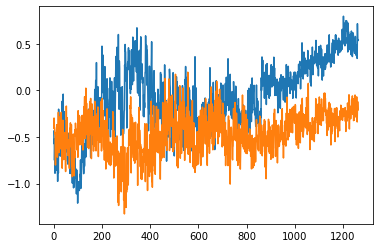

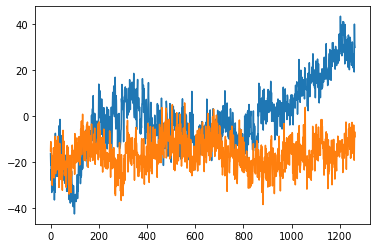

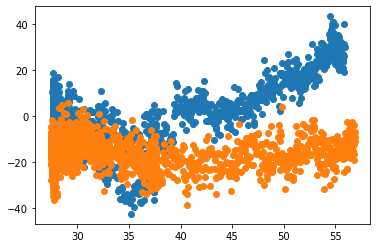

In [7]:
plt.plot(list(map(truediv, r1,t1)))
plt.plot(list(map(truediv, r2,t2)))
plt.show()

plt.plot(r1[:-1])
plt.plot(r2[:-1])

plt.show()

plt.scatter(t1[:-1],r1[:-1])
plt.scatter(t2[:-1],r2[:-1],)
plt.show()

In [7]:
def pixel_registration(array,cal_file,waves,ymin,ymax):
    #import cal file
    cal =  h5py.File(cal_file, "r")
    ROI =  list(cal['ROI'])
    pa  =  list(cal['fitparams'])
    
    def f(T, A, B): # this is your 'straight line' y=f(x)
        return A*T + B
    
    array=array[ymin:ymax,ROI[0]:ROI[1]]
    
    new = np.zeros([len(array),len(waves)])
    for i in range(len(array)):
        for l in range(len(waves)):    
            w=  waves[l]
            j = int(round(f(w,pa[0],pa[1])))
            values = array[i,j-1:j+1]
            value = np.mean(values)
            new[i,l] = value
    return(new)

In [8]:
im1 = pixel_registration(c1,cal_file1,waves,0,255)
im2 = pixel_registration(c2,cal_file2,waves,0,255)


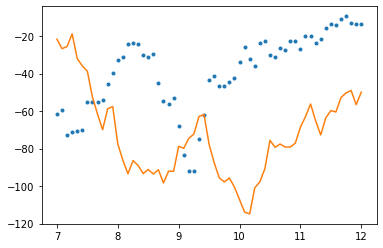

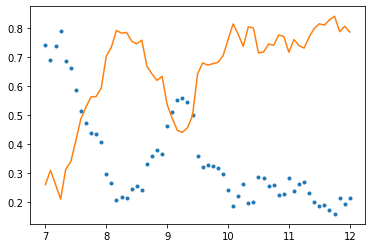

In [9]:
plt.plot(waves ,im1[125],'.')
plt.plot(waves ,im2[155])
plt.show()

totalrad = im1[125] + im2[155]
plt.plot(waves ,im1[125]/totalrad,'.')
plt.plot(waves ,im2[155]/totalrad)
plt.show()

In [11]:
def importWaveData(index):
    filename = path + 'Capture'+str(index)+'.hdf5'
    try:
        with h5py.File(filename, "r") as file:
             r1 = np.mean(file['image1'][()], axis = 0)
             r2 = np.mean(file['image2'][()], axis = 0)
             t1 = np.mean(file['temp1'][()])
             t2 = np.mean(file['temp2'][()])
        im1 = pixel_registration(r1-np.mean(r1),cal_file1,waves,0,255)
        im2 = pixel_registration(r2-np.mean(r2),cal_file2,waves,0,255)
        err = 0         
    except:
        print(index)
        err = 1
       
    if err:
         return(err,"nan","nan","nan","nan")
    else: 
        return(err,t1,t2,im1,im2)

In [19]:
def generateSQLquery(index):
    err,t1,t2,im1,im2 = importWaveData(index)
    ims = [im1,im2];
    if err:
        print("file " + str(index) + "is corrupted")
    else :
        string = "INSERT INTO rawdata VALUES"
        for c in [1,2]:
            for w in range(len(waves)):
                
                string += '(' + str(index) + ', '
                string += str(c)+ ', '
                string += str(round(waves[w],2))+ ', '
                string += str(0)+ ',' 
                string += str(err)+ ','
                if c == 1:
                    string += str(round(ims[c-1][125,w]))+ '),'
                else:
                    string += str(round(ims[c-1][155,w]))+ '),'
                    
        return(string[:-1]+ ';')
                
            

In [20]:
import pandas as pd
from SQL import create_db_connection, execute_query
import matplotlib.pyplot as plt
import h5py
import datetime
import numpy as np

In [24]:
#user_info
pw = "p0larizati0n"
user = "root"
db = "IRCSP"

'INSERT INTO rawdata VALUES(100, 1, 7.0, 0,0,-21),(100, 1, 7.08, 0,0,-21),(100, 1, 7.17, 0,0,-23),(100, 1, 7.25, 0,0,-24),(100, 1, 7.33, 0,0,-24),(100, 1, 7.42, 0,0,-21),(100, 1, 7.5, 0,0,-25),(100, 1, 7.58, 0,0,-25),(100, 1, 7.67, 0,0,-23),(100, 1, 7.75, 0,0,-22),(100, 1, 7.83, 0,0,-27),(100, 1, 7.92, 0,0,-26),(100, 1, 8.0, 0,0,-24),(100, 1, 8.08, 0,0,-23),(100, 1, 8.17, 0,0,-26),(100, 1, 8.25, 0,0,-36),(100, 1, 8.33, 0,0,-42),(100, 1, 8.42, 0,0,-46),(100, 1, 8.5, 0,0,-45),(100, 1, 8.58, 0,0,-44),(100, 1, 8.67, 0,0,-44),(100, 1, 8.75, 0,0,-32),(100, 1, 8.83, 0,0,-27),(100, 1, 8.92, 0,0,-32),(100, 1, 9.0, 0,0,-33),(100, 1, 9.08, 0,0,-38),(100, 1, 9.17, 0,0,-35),(100, 1, 9.25, 0,0,-37),(100, 1, 9.33, 0,0,-40),(100, 1, 9.42, 0,0,-33),(100, 1, 9.5, 0,0,-32),(100, 1, 9.58, 0,0,-32),(100, 1, 9.67, 0,0,-32),(100, 1, 9.75, 0,0,-32),(100, 1, 9.83, 0,0,-35),(100, 1, 9.92, 0,0,-34),(100, 1, 10.0, 0,0,-36),(100, 1, 10.08, 0,0,-41),(100, 1, 10.17, 0,0,-38),(100, 1, 10.25, 0,0,-42),(100, 1, 10.33, 

In [22]:
#connect to IRCSP database
connection = create_db_connection("localhost", user, pw, db)

MySQL Database connection successful


In [25]:
for index in range(1,2630):
    query = generateSQLquery(index);
    execute_query(connection, query)

Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successf

Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
491
file 491is corrupted
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query 

Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
950
file 950is corrupted
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
972
file 972is corrupted
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
991
file 991is corrupted
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query s

Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successf

Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successf

Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successf

Error: '1452 (23000): Cannot add or update a child row: a foreign key constraint fails (`ircsp`.`rawdata`, CONSTRAINT `rawdata_ibfk_1` FOREIGN KEY (`id`) REFERENCES `measurements` (`meas_id`))'
Error: '1452 (23000): Cannot add or update a child row: a foreign key constraint fails (`ircsp`.`rawdata`, CONSTRAINT `rawdata_ibfk_1` FOREIGN KEY (`id`) REFERENCES `measurements` (`meas_id`))'
Error: '1452 (23000): Cannot add or update a child row: a foreign key constraint fails (`ircsp`.`rawdata`, CONSTRAINT `rawdata_ibfk_1` FOREIGN KEY (`id`) REFERENCES `measurements` (`meas_id`))'
Error: '1452 (23000): Cannot add or update a child row: a foreign key constraint fails (`ircsp`.`rawdata`, CONSTRAINT `rawdata_ibfk_1` FOREIGN KEY (`id`) REFERENCES `measurements` (`meas_id`))'
Error: '1452 (23000): Cannot add or update a child row: a foreign key constraint fails (`ircsp`.`rawdata`, CONSTRAINT `rawdata_ibfk_1` FOREIGN KEY (`id`) REFERENCES `measurements` (`meas_id`))'
Error: '1452 (23000): Cannot a